### Intro to Variational Autoencoders

Bloggpost: https://pyro.ai/examples/vae.html

pytorch MNIST: https://github.com/pytorch/examples/blob/master/vae/main.py#L45

Good tutorial paper: https://arxiv.org/pdf/1606.05908.pdf

### Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
from torch.nn import functional as F

from torchvision import datasets, transforms
from torchvision.utils import save_image

import argparse
import easydict

### Parameters

Set parameters for vae training here

In [16]:
#parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
#parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                        help='batch size (default: 64)')
#args = parser.parse_args()

args = easydict.EasyDict({
    "batch_size": 64,
    "no_cuda": False,
    "epochs":8,
    "log_interval":10
})

use_cuda = not args.no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

device = torch.device("cuda" if use_cuda else "cpu")

### Load data

We use the MNIST dataset containing images of handwritten digits 1-9.

In [17]:
path = '/scratch/jonatank/data'

In [18]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(path, train=True, download=True, 
        transform=transforms.ToTensor()),
        batch_size=args.batch_size, shuffle=True,
        **kwargs)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(path, train=False, download=True, 
        transform=transforms.ToTensor()),
        batch_size=args.batch_size, shuffle=True, 
        **kwargs)

# next(iter(train_loader)) will give next batch: [data, label]

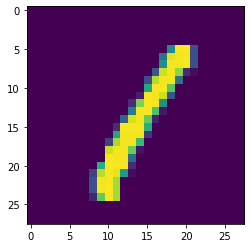

In [19]:
plt.figure()
plt.imshow(train_loader.dataset.data.numpy()[3])

### Define VAE

Below we build up VAE with encoder, decoder. 

In [20]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

### Init model and loss function

In [21]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

### Train and test functions for training

In [23]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        print(data.size())
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [24]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                #save_image(comparison.cpu(),
                         #'reconstruction/' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


### Training 

Saving images after we learn.

In [25]:
for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, 20).to(device)
            sample = model.decode(sample).cpu()
            #save_image(sample.view(64, 1, 28, 28),
                       #'results/sample_' + str(epoch) + '.png')

torch.Size([64, 1, 28, 28])
Train Epoch: 1 [0/60000 (0%)]	Loss: 547.346741
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [640/60000 (1%)]	Loss: 313.432434
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
Train Epoch: 1 [1280/60000 (2%)]	Loss: 240.539841
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64

torch.Size([64, 1, 28, 28])


KeyboardInterrupt: 

### Plot what we have learned 

By sampleing to the latent feild we can decode the sampeled values and create a "new" number.

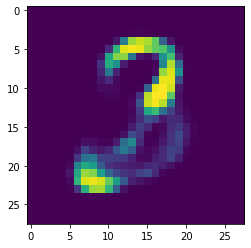

In [11]:
sample = torch.randn(64, 20).to(device)
sample = model.decode(sample).cpu()

plt.imshow(sample.view(64, 1, 28, 28)[0,0].detach().numpy())

## Image reconstruction

Fist we take a image and "remove part of it"

torch.Size([64, 28, 28])

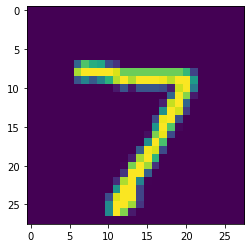

In [12]:
test_img = test_loader.dataset.data[:64].clone()
plt.imshow(test_img[0].numpy())
test_img.size()

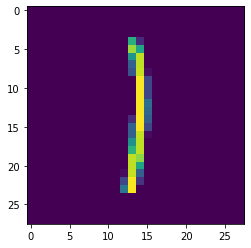

In [13]:
plt.imshow(test_img[40].numpy())

In [14]:
re_test_img = test_img[:,None,:,:].clone().float()

for i in range(args.batch_size):
    rand_idx = torch.randn(2)*10
    #print(rand_idx)
    re_test_img[i,0,int(abs(rand_idx[0])):int(abs(rand_idx[0]))+10, int(abs(rand_idx[1])):int(abs(rand_idx[1]))+10] = 255

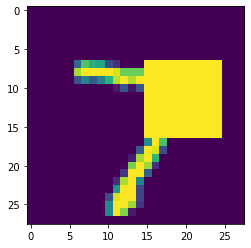

In [15]:
plt.imshow(re_test_img[0,0].numpy())

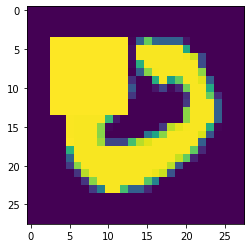

In [16]:
plt.imshow(re_test_img[25,0].numpy())

In [17]:
re_test_img.type()

'torch.FloatTensor'

### Encode image
To get latent representation of this image. 

In [18]:
re_test_loader = torch.utils.data.DataLoader(
        re_test_img,
        batch_size=args.batch_size, shuffle=False, 
        **kwargs)

In [19]:
model.eval()

with torch.no_grad():
    data = re_test_loader.dataset.data.to(device)
    recon_batch, mu, logvar = model(data)

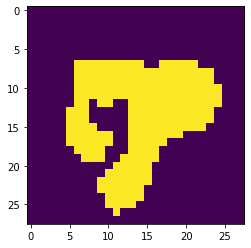

In [20]:
plt.imshow(recon_batch.view(64, 1, 28, 28)[0,0].detach().numpy())

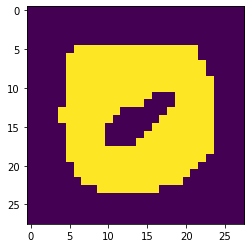

In [21]:
plt.imshow(recon_batch.view(64, 1, 28, 28)[25,0].detach().numpy())

The reconstructed image is relatively good. We try to find the "bad" part of the image by taking abs(reconstructed-original).

### Find bad part

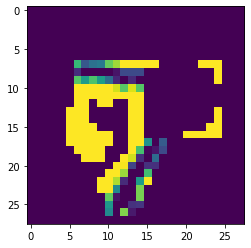

In [22]:
plt.imshow(abs(re_test_img[0,0].numpy()-255*recon_batch.view(64, 1, 28, 28)[0,0].detach().numpy()))

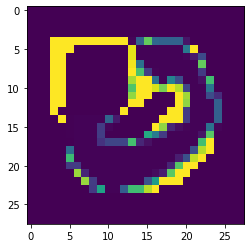

In [23]:
plt.imshow(abs(re_test_img[25,0].numpy()-255*recon_batch.view(64, 1, 28, 28)[25,0].detach().numpy()))

As seen above there are room for improvments.

### Experiments  

In [24]:
re_test_img = test_img[:,None,:,:].clone().float()
re_test_img[:,:,:,:] = 0
re_test_img[0,0,0:5,0:5] = 255

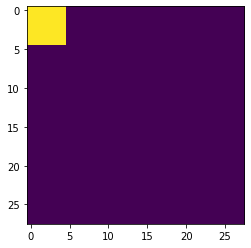

In [25]:
plt.imshow(re_test_img[0,0].numpy())

re_test_loader = torch.utils.data.DataLoader(
        re_test_img,
        batch_size=args.batch_size, shuffle=False, 
        **kwargs)

In [26]:
model.eval()

with torch.no_grad():
    data = re_test_loader.dataset.data.to(device)
    recon_batch, mu, logvar = model(data)

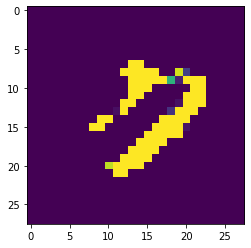

In [27]:
plt.imshow(recon_batch.view(64, 1, 28, 28)[0,0].detach().numpy())